In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import lru_cache
import numpy as np

%matplotlib inline
sns.set()

## Funciones auxiliares

### Funciones de carga y limpieza de datos

In [2]:
@lru_cache()
def get_data(path):
    df = pd.read_csv(path)
    return df

In [3]:
def clean_df_column_names(df):
    df.columns = [(col.lower()
                      .rstrip()
                      .lstrip()
                      .replace(' ', '_')
                      .replace(',', '')
                      .replace('(', '')
                      .replace(')', ''))
                    for col in df.columns]
    return df

In [4]:
def clean_unused_columns(dataset, cols=None):
    cols_to_remove = ['prod_category_a',
                          'actual_delivery_date',
                          'asp_currency',  # Está en moneda local
                          'asp', # Está en moneda local
                          'last_activity',
                          'submitted_for_approval', # Llena de 0s
                          'sales_contract_no', # Revela el target, se explica 
                                               # en su correspondiente sección
                          'asp_converted_currency']
    if cols is not None:
        cols_to_remove = cols
    return dataset.drop(cols_to_remove, axis=1, errors='ignore')

In [5]:
def convert_columns_to_correct_format(df):
    df['planned_delivery_start_date'] = pd.to_datetime(df['planned_delivery_start_date'])
    df['planned_delivery_end_date'] = pd.to_datetime(df['planned_delivery_end_date'])
    df['account_created_date'] = pd.to_datetime(df['account_created_date'])
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    return df

## Funciones de estilos para gráficos

In [6]:
stages = {
  'Closed Lost': 0,
  'Closed Won': 1,
}
def get_palette(mode='rgb_p', category=None):
    palette = {
        'rgb_p': {
            0: (0.847, 0.106, 0.376),
            1: (0.118, 0.533, 0.898),
        },
        'hex': {
            0: '#D81B60',
            1: '#1E88E5',
        }
    }

    if category == None:
        return palette[mode]
    return palette[mode][category]

def get_palette_neutro(mode='rgb_p'):
    return get_palette(mode, 1)

def get_title_style(category=None):
    return {
        'fontdict': {
            'fontsize': 18,
            'fontweight': 2,
        },
        'pad': 10,
    }

#### Funciones útiles

In [7]:
def calculate_na_proportion(serie):
    return serie.isna().sum() / len(serie)

In [8]:
def flat_df_index(df):
    def __flat_col(col):
        if not all(col):
            return col[0]
        return '_'.join(col)
    df.columns = [
         __flat_col(col) for col in df.columns
    ]
    return df

#### Constantes

In [9]:
RANDOM_STATE = 22
np.random.seed(RANDOM_STATE)

## Formación del pipeline

In [10]:
imputers = set()
encoders = set()
models = set()

## Carga de datasets

Se carga el dataset para el entrenamiento.

In [11]:
df = get_data('../data/Train_TP2_Datos_2020-2C.csv')
df = clean_df_column_names(df)

Se carga el dataset en el cual se harán las predicciones para la entrega en Kaggle

In [12]:
submit_df = get_data('../data/Test_TP2_Datos_2020-2C.csv')
submit_df = clean_df_column_names(submit_df)

## Observación: Sales Contract Number
Antes de seguir manipulando el dataset, desde la cátedra nos indicaron que hay una columna que delata el target, esta columna es `sales_contract_no`, es decir, aquellas oportunidades que tiene un número de contrato es porque son oportunidades ganadas. Tal como lo ilustra el siguiente gráfico.

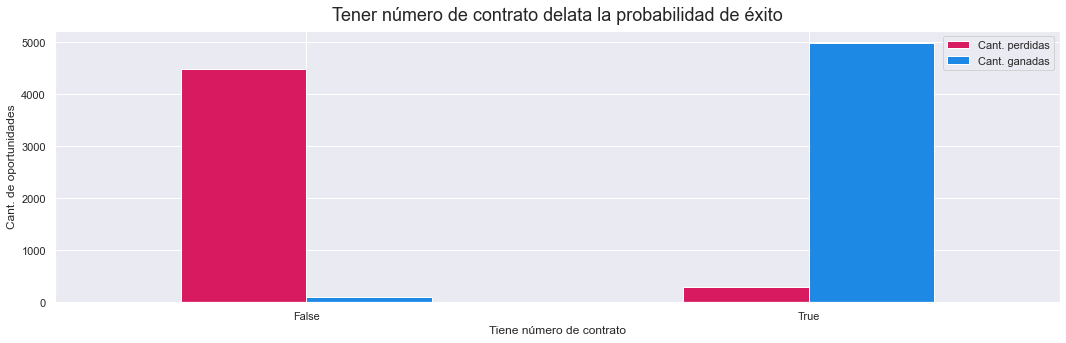

In [13]:
has_contract_no_vs_stage_won = df.groupby('opportunity_id').agg({
    'sales_contract_no': [('has_contract_no', lambda x: any(c != 'None' for c in x))],
    'stage': [('has_won', lambda x: any(c == 'Closed Won' for c in x))],
})
has_contract_no_vs_stage_won.columns = [col[1] for col in has_contract_no_vs_stage_won.columns]
has_contract_no_vs_stage_won = (has_contract_no_vs_stage_won
                                .reset_index()
                                .groupby(['has_contract_no', 'has_won'])['opportunity_id']
                                .count().unstack().reset_index())
has_contract_no_vs_stage_won.columns = ['Tiene número de contrato', 'Cant. perdidas', 'Cant. ganadas']
ax = has_contract_no_vs_stage_won.plot(x='Tiene número de contrato', y=['Cant. perdidas', 'Cant. ganadas'], 
                            kind='bar', figsize=(18, 5), rot=0, 
                            color=get_palette().values())
ax.set_ylabel('Cant. de oportunidades')
_ = ax.set_title('Tener número de contrato delata la probabilidad de éxito', **get_title_style())

Por esta razón, para utilizar cualquier modelo, esta variable será eliminada.

## Limpieza de datos

In [14]:
df.head().T

,0,1,2,3,4
id,27761,27760,27446,16808,16805
region,EMEA,EMEA,Americas,Americas,Americas
territory,None,None,NW America,NW America,NW America
pricing_delivery_terms_quote_appr,1,0,0,1,1
pricing_delivery_terms_approved,1,0,0,0,0
bureaucratic_code_0_approval,1,0,0,1,1
bureaucratic_code_0_approved,1,0,0,0,0
submitted_for_approval,0,0,0,0,0
bureaucratic_code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_5
account_created_date,6/16/2015,6/16/2015,4/21/2015,7/27/2013,7/27/2013


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 16947 non-null  int64  
 1   region                             16947 non-null  object 
 2   territory                          16947 non-null  object 
 3   pricing_delivery_terms_quote_appr  16947 non-null  int64  
 4   pricing_delivery_terms_approved    16947 non-null  int64  
 5   bureaucratic_code_0_approval       16947 non-null  int64  
 6   bureaucratic_code_0_approved       16947 non-null  int64  
 7   submitted_for_approval             16947 non-null  int64  
 8   bureaucratic_code                  16947 non-null  object 
 9   account_created_date               16947 non-null  object 
 10  source                             16947 non-null  object 
 11  billing_country                    16947 non-null  obj

In [16]:
def data_type_convertion(data):
    data['account_created_date'] = pd.to_datetime(data.account_created_date, 
                                                  errors='coerce')
    data['opportunity_created_date'] = pd.to_datetime(data.opportunity_created_date, 
                                                      errors='coerce')
    data['price'] = pd.to_numeric(data.price, errors='coerce')
    data['planned_delivery_start_date'] = pd.to_datetime(data.planned_delivery_start_date, 
                                                         errors='coerce')
    data['planned_delivery_end_date'] = pd.to_datetime(data.planned_delivery_end_date, 
                                                       errors='coerce')
    return data

In [17]:
df = data_type_convertion(df)

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,16947.0,1.766665e+04,6.940859e+03,4854.0,11953.00000,18114.00000,2.384550e+04,2.877300e+04
pricing_delivery_terms_quote_appr,16947.0,8.079896e-01,3.938928e-01,0.0,1.00000,1.00000,1.000000e+00,1.000000e+00
pricing_delivery_terms_approved,16947.0,5.835841e-01,4.929787e-01,0.0,0.00000,1.00000,1.000000e+00,1.000000e+00
bureaucratic_code_0_approval,16947.0,4.754824e-01,4.994133e-01,0.0,0.00000,0.00000,1.000000e+00,1.000000e+00
bureaucratic_code_0_approved,16947.0,3.188765e-01,4.660548e-01,0.0,0.00000,0.00000,1.000000e+00,1.000000e+00
submitted_for_approval,16947.0,0.000000e+00,0.000000e+00,0.0,0.00000,0.00000,0.000000e+00,0.000000e+00
opportunity_id,16947.0,5.335940e+03,3.324724e+03,0.0,2448.50000,5306.00000,7.698000e+03,1.280300e+04
price,356.0,3.203230e-01,7.471708e-02,0.2,0.26000,0.30750,3.700000e-01,5.600000e-01
asp,13738.0,7.012128e+00,1.885836e+01,0.0,0.36000,0.40000,5.050000e-01,8.000000e+01
asp_converted,13738.0,4.325537e-01,7.586588e-01,0.0,0.37326,0.41285,4.764900e-01,6.700000e+01


Se tienen 16947 registros en el df, con 52 columnas

In [19]:
df.shape

(16947, 52)

Pero se tienen 9841 oportunidades distintas

In [20]:
len(df.opportunity_id.unique())

9841

### Reducción de posibles stages

Como lo que se quiere predecir es la probabilidad de éxito (oportunidad `Closed Won`), y hay un desbalance en la cantidad de oportunidades por tipo de `stage` (como se muestra en el gráfico), solamente se mantienen los casos `Closed Won` y `Closed Lost`.

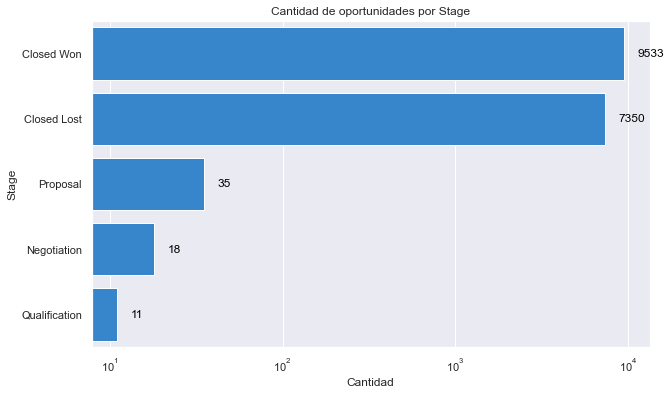

In [21]:
import math
data_stage_count = (
    df.stage.value_counts()
               .sort_values(ascending=False)
               .to_frame()
               .reset_index()
               .rename(columns={
                           'index': 'Stage', 
                           'stage': 'Cantidad'
                       }))
  
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Cantidad', y='Stage', 
                 data=data_stage_count, orient='h', 
                 palette=[get_palette_neutro()])
ax.set_title('Cantidad de oportunidades por Stage')
ax.set_xscale('log')
for index, row in data_stage_count.iterrows():
    ax.text(row['Cantidad'] * 1.2 , row.name, 
            round(row['Cantidad'], 2), 
            color='black', ha='left', 
            va='center')

Y reduciendo más la complejidad, se lo convierte a una variable binaria.

In [22]:
def encode_target(data):
    data = data[data.stage.eq('Closed Won') | data.stage.eq('Closed Lost')].copy()
    data['stage'] = data.stage.eq('Closed Won').astype(int)
    return data

In [23]:
df = encode_target(df)

### Columnas con datos no relevantes

- `prod_category_a`
- `actual_delivery_date`
- `asp_currency`
- `asp`
- `last_activity`
- `submitted_for_approval`
- `sales_contract_no`
- `asp_converted_currency`


#### prod_category_a, actual_delivery_date, last_activity, submitted_for_approval, asp_converted_currency

Solo cuentan con una categoría y esta no brindan información alguna. 

In [24]:
df.prod_category_a.value_counts()

Prod_Category_A_None    16883
Name: prod_category_a, dtype: int64

In [25]:
df.actual_delivery_date.value_counts()

NaT    16883
Name: actual_delivery_date, dtype: int64

In [26]:
df.last_activity.value_counts()

NaT    16883
Name: last_activity, dtype: int64

In [27]:
df.submitted_for_approval.value_counts()

0    16883
Name: submitted_for_approval, dtype: int64

In [28]:
df.asp_converted_currency.value_counts()

USD    16883
Name: asp_converted_currency, dtype: int64

In [29]:
df.asp.value_counts()

0.38000    799
0.40000    711
0.36000    558
0.42000    509
0.39000    465
          ... 
0.36100      1
0.47400      1
0.19500      1
0.00001      1
0.38300      1
Name: asp, Length: 297, dtype: int64

In [30]:
df.asp_currency.value_counts()

USD    7321
EUR    4501
JPY    4500
AUD     556
GBP       5
Name: asp_currency, dtype: int64

#### asp_currency, asp
Como se puede ver en la siguiente tabla, la conversión entre el `asp` y `asp_converted` es prácticamente contante para todas las posibles monedas, es decir, la conversión se hizo en el mismo momento para todas las monedas. Por una cuestión de unicidad, se descarta el `asp` original y se conserva `asp_converted` que está en la misma moneda para todas las oportunidades. 

In [31]:
def create_asp_ratio(data):
    df_filtered = data[['asp', 'asp_currency', 'asp_converted']].copy()
    df_filtered = df_filtered[~df_filtered.asp.isna() & ~df_filtered.asp_converted.isna()]
    data['asp_ratio'] = df_filtered.asp / df_filtered.asp_converted
    return data
df = create_asp_ratio(df)
df[['asp_currency', 'asp_ratio']].groupby('asp_currency').std()

,asp_ratio
asp_currency,
AUD,9.425580e-06
EUR,1.731599e-03
GBP,1.959081e-07
JPY,2.846901e+00
USD,0.000000e+00


##### Caso de Japón

Al parecer no está siguiendo la regla anterior. Aunque haya dado una desviación estándar mayor a las demás, por el siguiente gráfico, se puede ver que se mantiene una lineadidad.

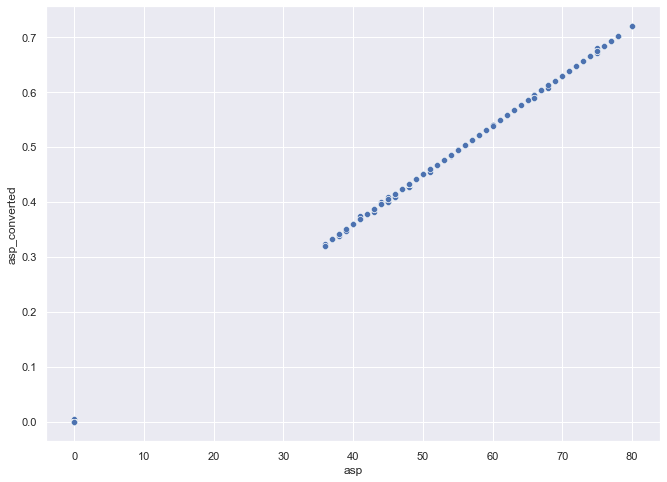

In [32]:
df_filtered_japan = df[df.asp_currency.eq('JPY')][['asp', 'asp_converted']]

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
_ = sns.scatterplot(data=df_filtered_japan, x='asp', y='asp_converted', ax=ax)

En conclusión, se pueden descartar las columnas `asp`, `asp_currency`, ya que no aportan información.

In [33]:
df = clean_unused_columns(df)

In [34]:
df.head().T

,0,1,2,3,4
id,27761,27760,27446,16808,16805
region,EMEA,EMEA,Americas,Americas,Americas
territory,None,None,NW America,NW America,NW America
pricing_delivery_terms_quote_appr,1,0,0,1,1
pricing_delivery_terms_approved,1,0,0,0,0
bureaucratic_code_0_approval,1,0,0,1,1
bureaucratic_code_0_approved,1,0,0,0,0
bureaucratic_code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_5
account_created_date,2015-06-16 00:00:00,2015-06-16 00:00:00,2015-04-21 00:00:00,2013-07-27 00:00:00,2013-07-27 00:00:00
source,None,None,Source_7,Source_11,Source_11


In [35]:
opportunity_qty = len(df.opportunity_id.unique())
opportunity_qty

9791

In [36]:
len(df.groupby(['opportunity_id']).groups.keys())

9791

In [37]:
common_data_columns = [
    'opportunity_id', 
    'opportunity_name', 

    'source',
    'opportunity_owner',
    'opportunity_created_date',
    'opportunity_type',

    'last_modified_date',
    'last_modified_by',

    'bureaucratic_code',
    'bureaucratic_code_0_approved',
    'bureaucratic_code_0_approval',

    'pricing_delivery_terms_approved',
    'pricing_delivery_terms_quote_appr',


    'account_name',
    'account_owner',                       
    'account_type',
    'account_created_date',

    'quote_type',
    'quote_expiry_date',

    'delivery_terms',   
    'region', 
    'territory', 
    'billing_country',   

#     'price',
#     'currency',

# TODO: Si bien los siguientes son unique en las oportunidades
# ver si tiene sentido que estén en la data de oportunidad
    
#                          'brand',
#                          'product_type',
#                          'size',
#                          'product_category_b',
#                          'product_family',
#                          'product_name',


#                          'asp_converted',
#                          'planned_delivery_start_date',
#                          'planned_delivery_end_date',
#                          'delivery_quarter',   
#                          'month',                       
#                          'delivery_year', ~ No cambia mucho la cardinalidad (9855)
#                          'trf',

#     'total_amount_currency',
#     'total_amount',
    
    'total_taxable_amount',
    'total_taxable_amount_currency',
    
    'stage',
]
def group_data_by_opp_id(data, common_data_columns):
    return data.groupby(common_data_columns).groups.keys()

opportunity_common_data = group_data_by_opp_id(df, common_data_columns)
len(opportunity_common_data)

9791

In [38]:
c = common_data_columns.copy()
c.remove('stage')
len(group_data_by_opp_id(submit_df, c))

1567

In [39]:
1567

1567

In [40]:
def create_opp_df(data, columns):
    return pd.DataFrame(data=data, columns=columns)

opp_df = create_opp_df(opportunity_common_data,
                       columns=common_data_columns)

In [41]:
opp_df.head().T

,0,1,2,3,4
opportunity_id,0,1,2,3,4
opportunity_name,Opportunity_Name_12598,Opportunity_Name_12600,Opportunity_Name_469,Opportunity_Name_415,Opportunity_Name_851
source,None,None,Source_7,Source_11,Source_11
opportunity_owner,Person_Name_18,Person_Name_20,Person_Name_8,Person_Name_8,Person_Name_8
opportunity_created_date,2015-12-07 00:00:00,2015-12-07 00:00:00,2015-12-08 00:00:00,2015-12-08 00:00:00,2015-12-08 00:00:00
opportunity_type,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_19,Opportunity_Type_19
last_modified_date,6/13/2016,1/15/2016,9/29/2016,3/27/2018,3/27/2018
last_modified_by,Person_Name_18,Person_Name_20,Person_Name_8,Person_Name_8,Person_Name_8
bureaucratic_code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_5
bureaucratic_code_0_approved,1,0,0,0,0


In [42]:
def create_sales_df(data, opp_columns):
    sales_df_columns = set(data.columns) - set(opp_columns)

    sales_df_columns = ['opportunity_id'] + list(sales_df_columns)
    if 'stage' in sales_df_columns:
        sales_df_columns.remove('stage')
    sales_df = data[sales_df_columns].copy()
    return clean_unused_columns(sales_df, ['id'])

sales_df = create_sales_df(df, common_data_columns)

In [43]:
sales_df.head().T

,0,1,2,3,4
opportunity_id,0,1,2,3,4
asp_ratio,0.884098,0.8841,1.0,1.0,1.0
delivery_year,2016,2016,2016,2018,2018
planned_delivery_start_date,2016-05-01 00:00:00,2016-01-18 00:00:00,2016-01-25 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00
total_amount,5272800.0,48230.0,83865.6,7421881.5,13357192.5
product_name,Product_Name_99,Product_Name_100,Product_Name_91,Product_Name_432,Product_Name_432
month,2016 - 5,2016 - 1,2016 - 1,2018 - 2,2018 - 2
trf,10,0,0,14,25
product_type,None,None,None,Product_Type_0,Product_Type_0
planned_delivery_end_date,2016-06-30 00:00:00,2016-01-20 00:00:00,2016-01-25 00:00:00,2018-03-31 00:00:00,2018-02-28 00:00:00


#### product_category_b
La gran mayoría ($\%93.96$) de los registros cuentan con valores nulos, con lo cual sacar conclusiones en base a `product_category_b`, no tendrá gran peso en la predicción. Se simplificará a `has_category_b` y más tarde se evaluará si tiene algún efecto en los modelos.

In [44]:
product_category_b_counts = sales_df.product_category_b.value_counts()
percentage_category_none = product_category_b_counts['None'] /  product_category_b_counts.sum()
print(percentage_category_none)
product_category_b_counts

0.9396434283006575


None                     15864
Other                      523
Product_Category_B_2        59
Product_Category_B_12       51
Product_Category_B_7        47
Product_Category_B_4        37
Product_Category_B_5        36
Product_Category_B_17       27
Product_Category_B_1        24
Product_Category_B_8        23
Product_Category_B_3        23
Product_Category_B_19       22
Product_Category_B_11       21
Product_Category_B_13       18
Product_Category_B_16       17
Product_Category_B_9        17
Product_Category_B_24       16
Product_Category_B_6         9
Product_Category_B_20        9
Product_Category_B_21        8
Product_Category_B_15        8
Product_Category_B_23        5
Product_Category_B_14        4
Product_Category_B_26        4
Product_Category_B_27        3
Product_Category_B_0         3
Product_Category_B_10        3
Product_Category_B_22        2
Name: product_category_b, dtype: int64

In [45]:
def create_has_category_b(data):
    data['has_category_b'] = data.product_category_b.ne('None').astype(int)
    return data

sales_df = create_has_category_b(sales_df)
sales_df = clean_unused_columns(sales_df, ['product_category_b'])

#### brand
La gran mayoría ($\%93.88$) de los registros cuentan con valores nulos, con lo cual sacar conclusiones en base a `brand`, no tendrá gran peso en la predicción. Se simplificará a `has_brand` y más tarde se evaluará si tiene algún efecto en los modelos.

In [46]:
brand_counts = sales_df.brand.value_counts()
percentage_brand_none = brand_counts['None'] /  brand_counts.sum()
print(percentage_brand_none)
brand_counts

0.9386364982526803


None        15847
Other         607
Brand_9       140
Brand_5        48
Brand_24       38
Brand_11       34
Brand_25       24
Brand_10       22
Brand_22       20
Brand_13       17
Brand_21       17
Brand_7        17
Brand_20       10
Brand_23       10
Brand_17        5
Brand_27        5
Brand_4         4
Brand_0         4
Brand_2         4
Brand_12        3
Brand_16        2
Brand_1         1
Brand_3         1
Brand_19        1
Brand_6         1
Brand_26        1
Name: brand, dtype: int64

In [47]:
def create_has_brand(data):
    data['has_brand'] = data.brand.ne('None').astype(int)
    return data
sales_df = create_has_brand(sales_df)
sales_df = clean_unused_columns(sales_df, ['brand'])

#### product_family

Territorios distintos 39


Product_Family_77     1345
Product_Family_133    1249
Product_Family_132     760
Product_Family_212     629
Product_Family_100     619
Product_Family_85      596
Product_Family_115     540
Product_Family_226     524
Product_Family_109     499
Product_Family_4       474
Product_Family_208     474
Product_Family_128     436
Product_Family_116     421
Product_Family_164     419
Product_Family_140     385
Product_Family_209     380
Product_Family_230     350
Product_Family_29      341
Product_Family_127     297
Product_Family_139     278
Product_Family_20      266
Product_Family_213     257
Product_Family_121     246
Product_Family_170     238
Product_Family_193     233
Product_Family_73      217
Product_Family_158     204
Product_Family_201     180
Product_Family_24      167
Product_Family_0       165
Product_Family_204     162
Product_Family_23      157
Product_Family_111     140
Product_Family_215     132
Product_Family_6       121
Product_Family_10      116
Product_Family_110     114
P

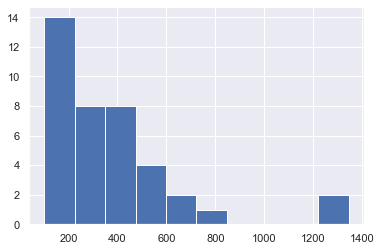

In [48]:
family_counts = sales_df.product_family.value_counts()

# TODO: reducir la cardinalidad de product_family
register_per_family = sales_df.product_family.value_counts()
register_per_family = register_per_family[register_per_family > 100]
_ = (register_per_family).hist(bins=10)
print("Territorios distintos", len(register_per_family))

"""
    # Posibles features para las oportunidades
    - Cantidad de familias distintas  
    - Promedio de la cardinalidad de cada familia
    - Desviación de la cardinalidad de cada familia
"""
register_per_family

#### size
La gran mayoría ($\%94.19$) de los registros cuentan con valores nulos, con lo cual sacar conclusiones en base a `size`, no tendrá gran peso en la predicción. Se simplificará a `has_size` y más tarde se evaluará si tiene algún efecto en los modelos.

In [49]:
size_counts = sales_df['size'].value_counts()
percentage_size_none = size_counts['None'] /  size_counts.sum()
print(percentage_size_none)
size_counts

0.9419534442930759


None      15903
Other       394
Size_3      356
Size_4      196
Size_1       25
Size_0        7
Size_2        2
Name: size, dtype: int64

In [50]:
def create_has_size(data):
    data['has_size'] = data['size'].ne('None').astype(int)
    return data
sales_df = create_has_size(sales_df)
sales_df = clean_unused_columns(sales_df, ['size'])

#### month, delivery_year, planned_delivery_start_date, planned_delivery_end_date
La columna se trata de un dato que no es átomico ya que contiene el mes y el año, probablemente el año está repitiendo data con `delivery_year`.

In [51]:
sales_df[['year_from_month','month']] = sales_df.month.str.split('-',expand=True)

In [52]:
sales_df['year_from_month'] = sales_df.year_from_month.astype(int)
sales_df['month'] = sales_df.month.astype(int)

Como no hay ningún registro donde `year_from_month` (la columna recién creada) y `delivery_year` sean distintos, entonces contiene la misma data. Entonces, alguna de las dos será eliminada.

In [53]:
sales_df[sales_df.year_from_month.ne(sales_df.delivery_year)]

,opportunity_id,asp_ratio,delivery_year,planned_delivery_start_date,total_amount,product_name,month,trf,product_type,planned_delivery_end_date,delivery_quarter,price,currency,asp_converted,total_amount_currency,product_family,has_category_b,has_brand,has_size,year_from_month


Analogamente, pasa lo mismo con la información de `month` y `delivery_year`, con `planned_delivery_start_date`. Como este último con tiene la información del día, que puede llegar a ser útil, se eliminarán las primeras dos mencionadas.

In [54]:
sales_df = clean_unused_columns(sales_df, ['year_from_month'])

In [55]:
sales_df['day_from_del_start'] = sales_df.planned_delivery_start_date.dt.day
sales_df['month_from_del_start'] = sales_df.planned_delivery_start_date.dt.month
sales_df['year_from_del_start'] = sales_df.planned_delivery_start_date.dt.year

In [56]:
sales_df[sales_df.year_from_del_start.ne(sales_df.delivery_year)]

,opportunity_id,asp_ratio,delivery_year,planned_delivery_start_date,total_amount,product_name,month,trf,product_type,planned_delivery_end_date,...,currency,asp_converted,total_amount_currency,product_family,has_category_b,has_brand,has_size,day_from_del_start,month_from_del_start,year_from_del_start


In [57]:
sales_df[sales_df.month_from_del_start.ne(sales_df.month)]

,opportunity_id,asp_ratio,delivery_year,planned_delivery_start_date,total_amount,product_name,month,trf,product_type,planned_delivery_end_date,...,currency,asp_converted,total_amount_currency,product_family,has_category_b,has_brand,has_size,day_from_del_start,month_from_del_start,year_from_del_start


In [58]:
sales_df = clean_unused_columns(sales_df, ['month', 'delivery_year',
                                           'day_from_del_start',
                                           'month_from_del_start',
                                           'year_from_del_start'])

In [59]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16883 entries, 0 to 16946
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   opportunity_id               16883 non-null  int64         
 1   asp_ratio                    13379 non-null  float64       
 2   planned_delivery_start_date  16883 non-null  datetime64[ns]
 3   total_amount                 16824 non-null  float64       
 4   product_name                 16883 non-null  object        
 5   trf                          16883 non-null  int64         
 6   product_type                 16883 non-null  object        
 7   planned_delivery_end_date    16808 non-null  datetime64[ns]
 8   delivery_quarter             16883 non-null  object        
 9   price                        356 non-null    float64       
 10  currency                     16883 non-null  object        
 11  asp_converted                13679 non-nu

#### product_name

Nombres distintos 446
Total nombres no usados: 376


Product_Name_100    976
Product_Name_226    836
Product_Name_231    577
Product_Name_491    524
Product_Name_4      474
                   ... 
Product_Name_242     58
Product_Name_322     56
Product_Name_97      53
Product_Name_287     52
Product_Name_449     51
Name: product_name, Length: 70, dtype: int64

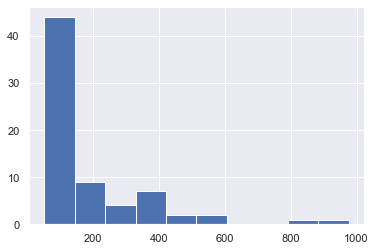

In [60]:
register_per_name = sales_df.product_name.value_counts()
register_per_name_high = register_per_name[register_per_name > 50]
_ = (register_per_name_high).hist(bins=10)
print("Nombres distintos", len(register_per_name))
print("Total nombres no usados:", len(register_per_name) - len(register_per_name_high))

"""
    # Posibles features para las oportunidades
    - Cantidad de productos distintos (Puede que coincida con el count)  
    - Promedio de la cardinalidad de cada producto
    - Desviación de la cardinalidad de cada producto
    - Cantidad de veces que se vendió en dicha región
"""
register_per_name_high

#### planned_delivery_start_date, planned_delivery_end_date => planned_delivery_interval

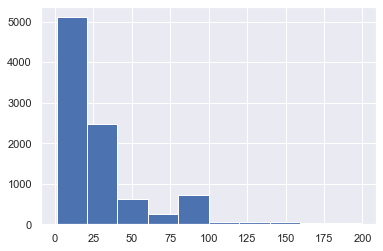

In [61]:
def create_delivery_interval(data):
    planned_delivery_interval = (data.planned_delivery_end_date - 
                                 data.planned_delivery_start_date).dt.days
    data['planned_delivery_interval'] = planned_delivery_interval
    return data


sales_df = create_delivery_interval(sales_df)

_ = sales_df.planned_delivery_interval[sales_df.planned_delivery_interval.gt(0) & 
                                       sales_df.planned_delivery_interval.lt(200)].hist(bins=10)


Outlier: Un primer outlier fue encontrado, un registro cuya `planned_delivery_end_date` es `2208-12-31`, lo cual no tiene sentido en este ámbito. Al ser un solo caso, será descartado.

In [62]:
sales_df[sales_df.planned_delivery_interval.gt(500)]

,opportunity_id,asp_ratio,planned_delivery_start_date,total_amount,product_name,trf,product_type,planned_delivery_end_date,delivery_quarter,price,currency,asp_converted,total_amount_currency,product_family,has_category_b,has_brand,has_size,planned_delivery_interval
6250,3869,1.000000,2016-12-01,16983000.0,Product_Name_130,50,None,2018-04-30,Q4,NaN,None,0.34000,USD,Product_Family_100,0,0,0,515.0
6591,4096,1.000000,2017-07-10,5702850.0,Product_Name_432,15,None,2019-07-10,Q3,NaN,None,0.38000,USD,Product_Family_209,0,0,0,730.0
6952,4283,1.000000,2017-08-07,471975.0,Product_Name_220,1,None,2020-08-07,Q3,NaN,None,0.38750,USD,Product_Family_133,0,0,0,1096.0
8051,5026,0.884106,2019-01-07,24633000.0,Product_Name_432,70,None,2020-06-30,Q1,NaN,None,0.39588,EUR,Product_Family_209,0,0,0,540.0
8052,5026,0.884106,2019-01-07,10472000.0,Product_Name_411,30,None,2020-06-30,Q1,NaN,None,0.39588,EUR,Product_Family_204,0,0,0,540.0
8397,5263,1.000000,2018-02-05,9808074.0,Product_Name_432,19,None,2019-06-28,Q1,NaN,None,0.53000,USD,Product_Family_209,0,0,0,508.0
15370,9773,0.884111,2018-10-14,134662.5,Product_Name_214,0,Other,2208-12-31,Q4,NaN,EUR,0.35629,EUR,Product_Family_127,1,1,1,69474.0


In [63]:
sales_df[sales_df.planned_delivery_interval.gt(2000)]
sales_df = sales_df.drop(sales_df.index[sales_df.planned_delivery_interval.gt(2000)])

In [64]:
sales_df.product_type.value_counts()

None              15871
Other               514
Product_Type_3      179
Product_Type_1      142
Product_Type_0       94
Product_Type_4       73
Product_Type_2        9
Name: product_type, dtype: int64

In [65]:
sales_df.head(20)

,opportunity_id,asp_ratio,planned_delivery_start_date,total_amount,product_name,trf,product_type,planned_delivery_end_date,delivery_quarter,price,currency,asp_converted,total_amount_currency,product_family,has_category_b,has_brand,has_size,planned_delivery_interval
0,0,0.884098,2016-05-01,5272800.0,Product_Name_99,10,None,2016-06-30,Q2,NaN,None,0.58817,EUR,Product_Family_77,0,0,0,60.0
1,1,0.884100,2016-01-18,48230.0,Product_Name_100,0,None,2016-01-20,Q1,NaN,None,0.59948,EUR,Product_Family_77,0,0,0,2.0
2,2,1.000000,2016-01-25,83865.6,Product_Name_91,0,None,2016-01-25,Q1,NaN,None,0.48000,USD,Product_Family_81,0,0,0,0.0
3,3,1.000000,2018-02-01,7421881.5,Product_Name_432,14,Product_Type_0,2018-03-31,Q1,0.42,USD,0.53000,USD,Product_Family_209,1,1,1,58.0
4,4,1.000000,2018-02-01,13357192.5,Product_Name_432,25,Product_Type_0,2018-02-28,Q1,0.42,USD,0.53000,USD,Product_Family_209,1,1,1,27.0
5,5,1.000000,2018-02-01,14838277.5,Product_Name_432,28,Product_Type_0,2018-03-31,Q1,0.42,USD,0.53000,USD,Product_Family_209,1,1,1,58.0
6,6,1.000000,2017-02-01,2659494.6,Product_Name_308,7,None,2017-05-01,Q1,NaN,None,0.38000,USD,Product_Family_164,0,0,0,89.0
7,7,1.000000,2016-01-25,50688.0,Product_Name_251,0,None,2016-01-25,Q1,NaN,None,0.48000,USD,Product_Family_143,0,0,0,0.0
8,8,NaN,2016-02-29,15600.0,Product_Name_6,0,None,2016-02-29,Q1,NaN,None,NaN,JPY,Product_Family_6,0,0,0,0.0
9,8,NaN,2016-02-29,4400.0,Product_Name_4,0,None,2016-02-29,Q1,NaN,None,NaN,JPY,Product_Family_4,0,0,0,0.0


In [66]:
# TODO: reducir categorias < 200 -> other
sales_df.currency.value_counts()

None    15988
EUR       474
USD       420
Name: currency, dtype: int64

In [67]:
opp_df[opp_df.opportunity_id.eq(9)].T

,9
opportunity_id,9
opportunity_name,Opportunity_Name_6817
source,None
opportunity_owner,Person_Name_50
opportunity_created_date,2015-12-09 00:00:00
opportunity_type,Opportunity_Type_7
last_modified_date,4/5/2016
last_modified_by,Person_Name_50
bureaucratic_code,Bureaucratic_Code_5
bureaucratic_code_0_approved,0


#### Aggregación de `sales` en `oportunidades`

In [68]:
def agregate_sales_to_opp(sales, opp):
    mean_per_opp = sales.groupby('opportunity_id').agg({
        'trf': [
            'mean', 
            'sum', 
            'count', 
        ],
        'planned_delivery_interval': [
            'mean', 
        ],
        'asp_ratio': [
            'mean'
        ],
        'total_amount': [
            'mean', # TODO: está dando malos resultados
            'sum', # TODO: está dando malos resultados
        ],
    }).reset_index()

    mean_per_opp = flat_df_index(mean_per_opp)
    opp = opp.merge(mean_per_opp, on='opportunity_id')
    return (sales, opp)

sales_df, opp_df = agregate_sales_to_opp(sales_df, opp_df)

In [69]:
opp_df.T

,0,1,2,3,4,5,6,7,8,9,...,9781,9782,9783,9784,9785,9786,9787,9788,9789,9790
opportunity_id,0,1,2,3,4,5,6,7,8,9,...,12794,12795,12796,12797,12798,12799,12800,12801,12802,12803
opportunity_name,Opportunity_Name_12598,Opportunity_Name_12600,Opportunity_Name_469,Opportunity_Name_415,Opportunity_Name_851,Opportunity_Name_939,Opportunity_Name_1618,Opportunity_Name_8227,Opportunity_Name_6151,Opportunity_Name_6817,...,Opportunity_Name_9518,Opportunity_Name_9259,Opportunity_Name_4046,Opportunity_Name_4060,Opportunity_Name_5088,Opportunity_Name_7202,Opportunity_Name_11979,Opportunity_Name_9245,Opportunity_Name_5843,Opportunity_Name_9911
source,None,None,Source_7,Source_11,Source_11,Source_11,Source_11,Source_7,None,None,...,None,None,None,Source_9,None,Source_9,None,Source_7,None,None
opportunity_owner,Person_Name_18,Person_Name_20,Person_Name_8,Person_Name_8,Person_Name_8,Person_Name_8,Person_Name_8,Person_Name_8,Person_Name_50,Person_Name_50,...,Person_Name_4,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_3,Person_Name_3
opportunity_created_date,2015-12-07 00:00:00,2015-12-07 00:00:00,2015-12-08 00:00:00,2015-12-08 00:00:00,2015-12-08 00:00:00,2015-12-08 00:00:00,2015-12-08 00:00:00,2015-12-09 00:00:00,2015-12-09 00:00:00,2015-12-09 00:00:00,...,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-04 00:00:00,2015-12-05 00:00:00,2015-12-05 00:00:00
opportunity_type,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_19,Opportunity_Type_19,Opportunity_Type_19,Opportunity_Type_19,Opportunity_Type_1,Opportunity_Type_7,Opportunity_Type_7,...,Opportunity_Type_19,Opportunity_Type_1,Opportunity_Type_7,Opportunity_Type_8,Opportunity_Type_19,Opportunity_Type_1,Opportunity_Type_19,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_19
last_modified_date,6/13/2016,1/15/2016,9/29/2016,3/27/2018,3/27/2018,3/27/2018,10/7/2016,12/9/2015,4/5/2016,4/5/2016,...,12/11/2015,2/25/2016,2/29/2016,12/18/2015,10/21/2016,4/1/2016,10/10/2016,1/19/2016,1/22/2016,9/28/2016
last_modified_by,Person_Name_18,Person_Name_20,Person_Name_8,Person_Name_8,Person_Name_8,Person_Name_8,Person_Name_8,Person_Name_8,Person_Name_50,Person_Name_50,...,Person_Name_4,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_13,Person_Name_3,Person_Name_3
bureaucratic_code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_5,Bureaucratic_Code_5,Bureaucratic_Code_5,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_5,...,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4
bureaucratic_code_0_approved,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1


In [70]:
def create_amount_taxable_difference(df):
    df['amount_taxable_difference'] = df.total_amount_sum - df.total_taxable_amount
    return df

opp_df = create_amount_taxable_difference(opp_df)

In [71]:
amount_taxable_difference = opp_df.amount_taxable_difference

In [72]:
len(amount_taxable_difference[amount_taxable_difference.ne(0)])

759

In [73]:
opp_df[amount_taxable_difference.ne(0)].T

,27,47,52,94,116,136,169,177,178,202,...,9711,9712,9723,9732,9735,9738,9754,9756,9789,9790
opportunity_id,27,47,53,96,118,140,173,181,182,206,...,12724,12725,12736,12745,12748,12751,12767,12769,12802,12803
opportunity_name,Opportunity_Name_12137,Opportunity_Name_2683,Opportunity_Name_5030,Opportunity_Name_11275,Opportunity_Name_7405,Opportunity_Name_9872,Opportunity_Name_6286,Opportunity_Name_11751,Opportunity_Name_11752,Opportunity_Name_4948,...,Opportunity_Name_11268,Opportunity_Name_12650,Opportunity_Name_7283,Opportunity_Name_3526,Opportunity_Name_2802,Opportunity_Name_1730,Opportunity_Name_7576,Opportunity_Name_5039,Opportunity_Name_5843,Opportunity_Name_9911
source,None,None,Source_7,None,None,None,None,Source_1,Source_1,None,...,None,Source_11,Source_13,None,None,Source_11,Source_13,None,None,None
opportunity_owner,Person_Name_18,Person_Name_3,Person_Name_49,Person_Name_3,Person_Name_3,Person_Name_3,Person_Name_3,Person_Name_3,Person_Name_3,Person_Name_3,...,Person_Name_3,Person_Name_3,Person_Name_3,Person_Name_13,Person_Name_18,Person_Name_8,Person_Name_11,Person_Name_63,Person_Name_3,Person_Name_3
opportunity_created_date,2015-12-12 00:00:00,2015-12-18 00:00:00,2015-12-21 00:00:00,2015-12-24 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-14 00:00:00,2016-01-20 00:00:00,...,2015-11-14 00:00:00,2015-11-14 00:00:00,2015-11-17 00:00:00,2015-11-24 00:00:00,2015-11-25 00:00:00,2015-11-26 00:00:00,2015-11-30 00:00:00,2015-11-30 00:00:00,2015-12-05 00:00:00,2015-12-05 00:00:00
opportunity_type,Opportunity_Type_2,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_19,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_7,...,Opportunity_Type_1,Opportunity_Type_19,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_7,Opportunity_Type_19,Opportunity_Type_1,Opportunity_Type_1,Opportunity_Type_19
last_modified_date,1/12/2017,9/29/2016,1/27/2016,9/29/2016,12/4/2016,12/4/2016,12/4/2016,12/4/2016,12/4/2016,12/4/2016,...,2/23/2016,11/26/2015,9/28/2016,1/7/2016,1/12/2017,2/22/2017,12/12/2016,8/24/2018,1/22/2016,9/28/2016
last_modified_by,Person_Name_39,Person_Name_3,Person_Name_49,Person_Name_3,Person_Name_47,Person_Name_47,Person_Name_47,Person_Name_47,Person_Name_47,Person_Name_47,...,Person_Name_3,Person_Name_3,Person_Name_3,Person_Name_13,Person_Name_39,Person_Name_33,Person_Name_11,Person_Name_63,Person_Name_3,Person_Name_3
bureaucratic_code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,...,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_5,Bureaucratic_Code_4,Bureaucratic_Code_4
bureaucratic_code_0_approved,0,1,0,1,1,1,0,1,1,0,...,0,1,1,1,0,0,0,0,1,1


In [74]:
# TODO: reducir categorias < 200 -> other
opp_df.delivery_terms.value_counts()

Delivery_Terms_4    3446
Delivery_Terms_2    3218
Delivery_Terms_1    1985
Delivery_Terms_5     522
Delivery_Terms_6     434
Delivery_Terms_8     114
Delivery_Terms_7      36
Delivery_Terms_3      32
Delivery_Terms_0       4
Name: delivery_terms, dtype: int64

In [75]:
opp_df.region.value_counts()

EMEA           3237
Americas       2452
APAC           2079
Japan          1885
Middle East     138
Name: region, dtype: int64

In [76]:
opp_df.quote_type.value_counts()

Non Binding    9661
Binding         130
Name: quote_type, dtype: int64

In [77]:
def create_quote_type_binding(data):
    data['quote_type_binding'] = data.quote_type.eq('Binding').astype(int)
    return data 
opp_df = create_quote_type_binding(opp_df)

In [78]:
# TODO: reducir categorias < 200 -> other
opp_df.account_type.value_counts()

Account_Type_2    4676
Account_Type_0    3418
Account_Type_5    1445
Account_Type_1     124
None               103
Account_Type_6      17
Account_Type_4       8
Name: account_type, dtype: int64

In [79]:
# TODO: reducir categorias < 200 -> other
opp_df.bureaucratic_code.value_counts()

Bureaucratic_Code_4    7400
Bureaucratic_Code_5    2080
Bureaucratic_Code_1     177
Bureaucratic_Code_2     120
Bureaucratic_Code_0      11
Bureaucratic_Code_3       2
Bureaucratic_Code_6       1
Name: bureaucratic_code, dtype: int64

In [80]:
# TODO: reducir categorias < 1000 -> other
opp_df.source.value_counts()

None         4874
Source_7     2063
Source_9      871
Source_11     847
Source_13     533
Source_3      302
Source_10      89
Source_1       88
Source_2       68
Source_4       32
Source_6       17
Source_0        4
Source_12       2
Source_5        1
Name: source, dtype: int64

In [81]:
# TODO: reducir categorias < 500 -> other
opp_df.opportunity_type.value_counts()

Opportunity_Type_1     5128
Opportunity_Type_7     1995
Opportunity_Type_19    1277
Opportunity_Type_8      735
Opportunity_Type_3      182
Opportunity_Type_12     138
Opportunity_Type_20     135
Opportunity_Type_2       53
Opportunity_Type_4       47
Opportunity_Type_10      15
Opportunity_Type_9       13
Opportunity_Type_5       12
Opportunity_Type_18      10
Opportunity_Type_14      10
Opportunity_Type_15       9
Opportunity_Type_0        7
Opportunity_Type_22       5
Opportunity_Type_23       5
Opportunity_Type_13       4
Opportunity_Type_21       3
Opportunity_Type_17       3
Opportunity_Type_11       2
Opportunity_Type_16       1
Opportunity_Type_24       1
Opportunity_Type_6        1
Name: opportunity_type, dtype: int64

#### territory

Territorios distintos 57


Thailand                173
Indonesia               151
Austria                 145
Philippines             109
Jordan                  100
Canada                   74
Luxembourg               70
Portugal                 66
Poland                   59
Vietnam                  51
Cyprus                   44
New Zealand              38
Denmark                  38
Taiwan                   33
Carribean                31
Turkey                   29
Hungary                  28
UAE (Dubai)              28
Switzerland              21
Norway                   19
South Korea              15
KSA                      13
Sweden                   12
Greece                    9
Central America           9
Ireland                   9
Estonia                   8
South America             8
Kazakhstan                7
Malta                     6
Macedonia                 6
Pakistan                  6
Bulgaria                  5
Tunisia                   5
Ukraine                   5
Malaysia            

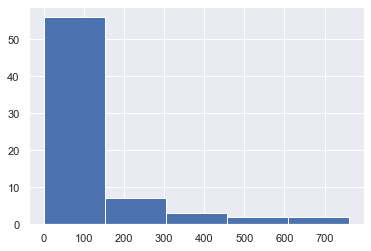

In [82]:
# TODO: reducir la cardinalidad de territory
register_per_territory = df.territory.value_counts()
register_per_territory_lower = register_per_territory[register_per_territory < 200]
_ = register_per_territory[register_per_territory < 800].hist(bins=5)
print("Territorios distintos", len(register_per_territory_lower))
register_per_territory_lower

---

## Función auxiliar
Función auxiliar para manipular el dataset con los datos nuevos.

In [83]:
def tune_dataset(data, common_opp_data_columns):
    data = data_type_convertion(data)
    data = create_asp_ratio(data)
    opp_shared_data = group_data_by_opp_id(data, common_opp_data_columns)
    opp_df = create_opp_df(opp_shared_data, common_opp_data_columns)
    sales_df = create_sales_df(data, common_opp_data_columns)
    sales_df = create_has_category_b(sales_df)
    sales_df = create_has_brand(sales_df)
    sales_df = create_has_size(sales_df)
    sales_df = create_delivery_interval(sales_df)

    opp_df = create_quote_type_binding(opp_df)
    
    sales_df, opp_df = agregate_sales_to_opp(sales_df, opp_df)
    opp_df = create_amount_taxable_difference(opp_df)
    
    return sales_df, opp_df

In [161]:
def create_submit_X_data(submit_df, common_data_columns, transformer):
    submit_common_cols = common_data_columns.copy()
    submit_df = submit_df.copy()
    if 'stage' in submit_common_cols:
        submit_common_cols.remove('stage')
    sal, submit_opp_df = tune_dataset(submit_df, submit_common_cols)
    data_raw = transformer.transform(submit_opp_df).todense()
    print(f"Sales qty: {len(sal)}")
    print(f"Opportunities qty: {len(submit_opp_df)}")
    data = pd.DataFrame(data_raw, columns=submit_common_cols)    
    return data
    

In [85]:
def test_over_submit_approximation(model, X_submit, X_train):    
    data = X_submit
    y_submit = submit_df.groupby('opportunity_id').first().sales_contract_no.ne('None').astype(int)
    show_model_stats(model, X_train, data, y_train, y_submit)

In [86]:
def prepare_submit(model, X_submit, name=''):
    data = X_submit
    y_hat = model.predict_proba(data)
    result = pd.concat([(submit_df.opportunity_id.to_frame()
                     .groupby('opportunity_id')
                     .first().reset_index()), 
           pd.Series(y_hat[:,1], name='target')], axis=1)
    if name:
        result.to_csv(f'../data/{name}.csv', index=False)
        
    return result

---

In [87]:
from sklearn.metrics import log_loss

In [88]:
from sklearn.metrics import plot_confusion_matrix

In [89]:
def show_model_stats(model, X_train, X_test, y_train, y_test):
    y_hat = model.predict_proba(X_test)
    print('log_loss test:', log_loss(y_test, y_hat))
    _ = plot_confusion_matrix(model, X_test, y_test)

    print('Train score', model.score(X_train, y_train))
    print('Test score', model.score(X_test, y_test))

### Constantes

In [90]:
CHECK_FEATURE_IMPORTANCE = True

## Testeo primeros modelos

#### Primer modelo

##### Preparación de datos

In [91]:
# first_iteration
columns_to_use_cat = [
    'bureaucratic_code',
    'account_type',
    'delivery_terms',
    'region',
]
columns_to_use_num = [
    'bureaucratic_code_0_approved',
    'bureaucratic_code_0_approval',
    'pricing_delivery_terms_approved',
    'pricing_delivery_terms_quote_appr',
    'quote_type_binding',
#     'price',
    'total_taxable_amount',
    'trf_mean',
    'trf_sum',
    'trf_count',
    'planned_delivery_interval_mean',
    'asp_ratio_mean',
    'total_amount_mean',
    'total_amount_sum',
    'amount_taxable_difference',
]


In [92]:
opp_df.head()

,opportunity_id,opportunity_name,source,opportunity_owner,opportunity_created_date,opportunity_type,last_modified_date,last_modified_by,bureaucratic_code,bureaucratic_code_0_approved,...,stage,trf_mean,trf_sum,trf_count,planned_delivery_interval_mean,asp_ratio_mean,total_amount_mean,total_amount_sum,amount_taxable_difference,quote_type_binding
0,0,Opportunity_Name_12598,None,Person_Name_18,2015-12-07,Opportunity_Type_1,6/13/2016,Person_Name_18,Bureaucratic_Code_4,1,...,0,10.0,10,1,60.0,0.884098,5272800.0,5272800.0,0.0,0
1,1,Opportunity_Name_12600,None,Person_Name_20,2015-12-07,Opportunity_Type_1,1/15/2016,Person_Name_20,Bureaucratic_Code_4,0,...,1,0.0,0,1,2.0,0.884100,48230.0,48230.0,0.0,0
2,2,Opportunity_Name_469,Source_7,Person_Name_8,2015-12-08,Opportunity_Type_1,9/29/2016,Person_Name_8,Bureaucratic_Code_4,0,...,1,0.0,0,1,0.0,1.000000,83865.6,83865.6,0.0,0
3,3,Opportunity_Name_415,Source_11,Person_Name_8,2015-12-08,Opportunity_Type_19,3/27/2018,Person_Name_8,Bureaucratic_Code_5,0,...,0,14.0,14,1,58.0,1.000000,7421881.5,7421881.5,0.0,0
4,4,Opportunity_Name_851,Source_11,Person_Name_8,2015-12-08,Opportunity_Type_19,3/27/2018,Person_Name_8,Bureaucratic_Code_5,0,...,0,25.0,25,1,27.0,1.000000,13357192.5,13357192.5,0.0,0


In [93]:
total_columns = columns_to_use_cat + columns_to_use_num
total_columns_s = pd.Series(total_columns)

### Transformaciones

In [94]:
from scipy import sparse

In [95]:
class BasicTransformer:
    def __init__(self, encoder, inputer, cat_cols, num_cols):
        self.encoder = encoder
        self.inputer = inputer
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        
    def fit(self, data):
        self.encoder.fit(data[self.cat_cols])
        self.inputer.fit(data[self.num_cols])
        return self
        
    def transform(self, data):
        cat_data = self.encoder.transform(data[self.cat_cols])
        num_data = self.inputer.transform(data[self.num_cols])
        return sparse.hstack([cat_data, num_data])

In [96]:
from sklearn.preprocessing import OneHotEncoder

In [97]:
enc = OneHotEncoder(handle_unknown='error')
encoders.add(enc)
enc

OneHotEncoder()

In [98]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputers.add(imp_mean)
imp_mean

SimpleImputer()

In [99]:
transformer = BasicTransformer(enc, imp_mean, columns_to_use_cat, columns_to_use_num)

In [100]:
transformer.fit(opp_df)

In [101]:
cat_labels = list(enc.get_feature_names()) 

In [102]:
total_columns = cat_labels + columns_to_use_num

In [103]:
data_raw = transformer.transform(opp_df).todense()

In [104]:
data = pd.DataFrame(data_raw, columns=total_columns)

In [105]:
data.shape

(9791, 42)

In [106]:
corr_matrix = data.corr()

In [107]:
corr_matrix.shape

(42, 42)

In [108]:
len(total_columns)

42

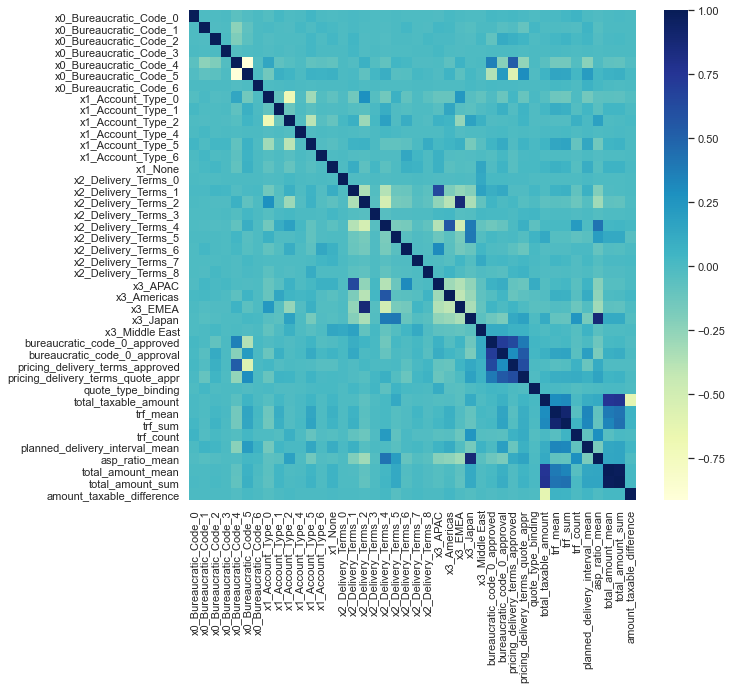

In [109]:
fig, ax = plt.subplots(figsize=(10, 9))
_ = sns.heatmap(corr_matrix, 
                xticklabels=total_columns,
                yticklabels=total_columns,
                cmap="YlGnBu",
                ax=ax)

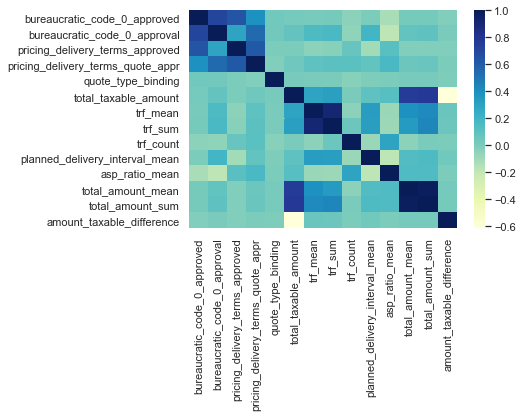

In [110]:
_ = sns.heatmap(opp_df[columns_to_use_num].corr(), cmap="YlGnBu")

In [111]:
if CHECK_FEATURE_IMPORTANCE:
    total_columns = cat_labels + columns_to_use_num + ['random_value']
    data['random_value'] = np.random.rand(data.shape[0])
data.shape

(9791, 43)

In [112]:
target = opp_df.stage

### Spliteo de datos

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [115]:
from sklearn.model_selection import GridSearchCV

## Modelos

In [116]:
models = {}

DecisonTree
---

In [117]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
"""
Best params:
    1st: max_depth=6, min_samples_split=20
    2nd: max_depth=6, min_samples_split=10
    3rd: max_depth=8, min_samples_split=8
    4th: max_depth=8, min_samples_split=9
"""
tree = GridSearchCV(tree, param_grid={
    'max_depth': [8, 10, 15],
    'min_samples_split': [8, 9, 10, 11],
})
tree.fit(X_train, y_train)
models['basic_des_tree'] = tree

In [118]:
tree.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_split=9, random_state=22)

In [119]:
tree.best_params_

{'max_depth': 8, 'min_samples_split': 9}

log_loss test: 0.8878424104752257
Train score 0.8160152526215443
Test score 0.7781862745098039


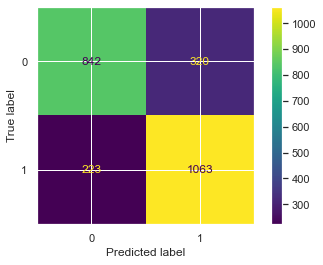

In [120]:
"""
Con todos los features:
log_loss test: 0.8304249908211014
Train score 0.8232330110309138
Test score 0.7769607843137255
"""
show_model_stats(tree.best_estimator_, X_train, X_test, y_train, y_test)

In [121]:
tree.best_estimator_.tree_.max_depth

8

In [122]:
from sklearn.tree import plot_tree

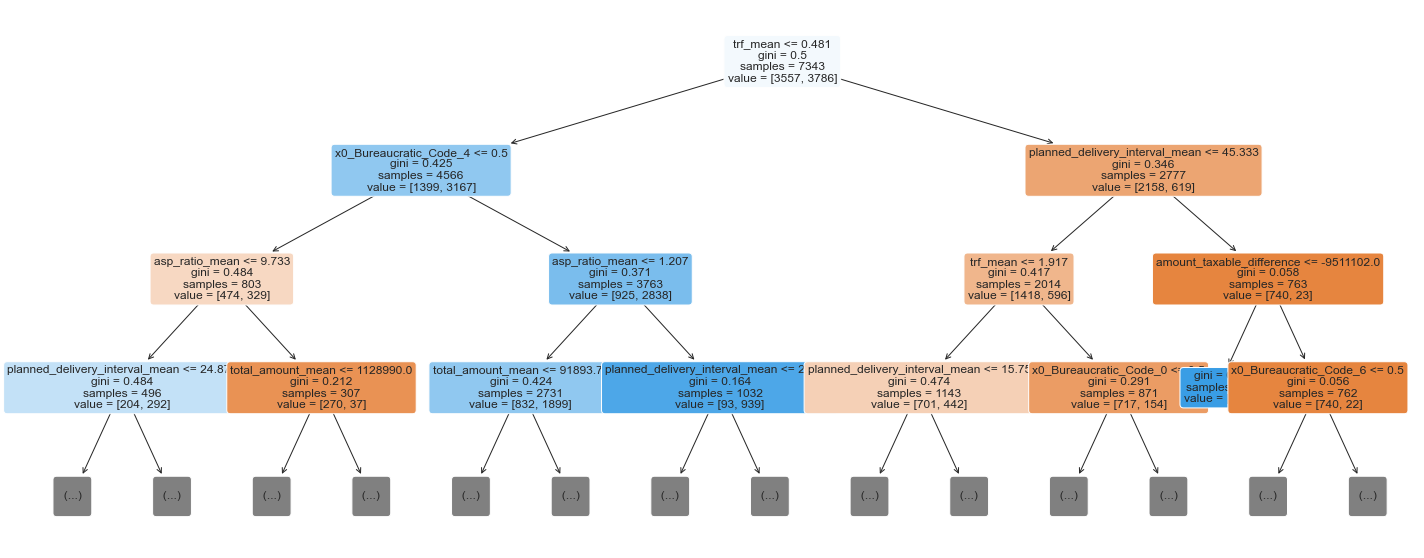

In [123]:
fig, ax = plt.subplots(figsize=(25, 10))
_ = plot_tree(tree.best_estimator_, feature_names=total_columns,
              filled=True, rounded=True,
              max_depth=3, fontsize=12, ax=ax)

random variable importance: 0.014777551064694725
columnas más importantes que la variable random:
 4             x0_Bureaucratic_Code_4
7                  x1_Account_Type_0
33              total_taxable_amount
34                          trf_mean
37    planned_delivery_interval_mean
38                    asp_ratio_mean
39                 total_amount_mean
dtype: object
35 0.014777551064694725
                      feature_name  feature_importance
36               x1_Account_Type_0            0.019393
37            total_taxable_amount            0.043363
38          x0_Bureaucratic_Code_4            0.087176
39               total_amount_mean            0.093676
40  planned_delivery_interval_mean            0.102594
41                  asp_ratio_mean            0.104229
42                        trf_mean            0.449977


,feature_name,feature_importance
36,x1_Account_Type_0,0.019393
37,total_taxable_amount,0.043363
38,x0_Bureaucratic_Code_4,0.087176
39,total_amount_mean,0.093676
40,planned_delivery_interval_mean,0.102594
41,asp_ratio_mean,0.104229
42,trf_mean,0.449977


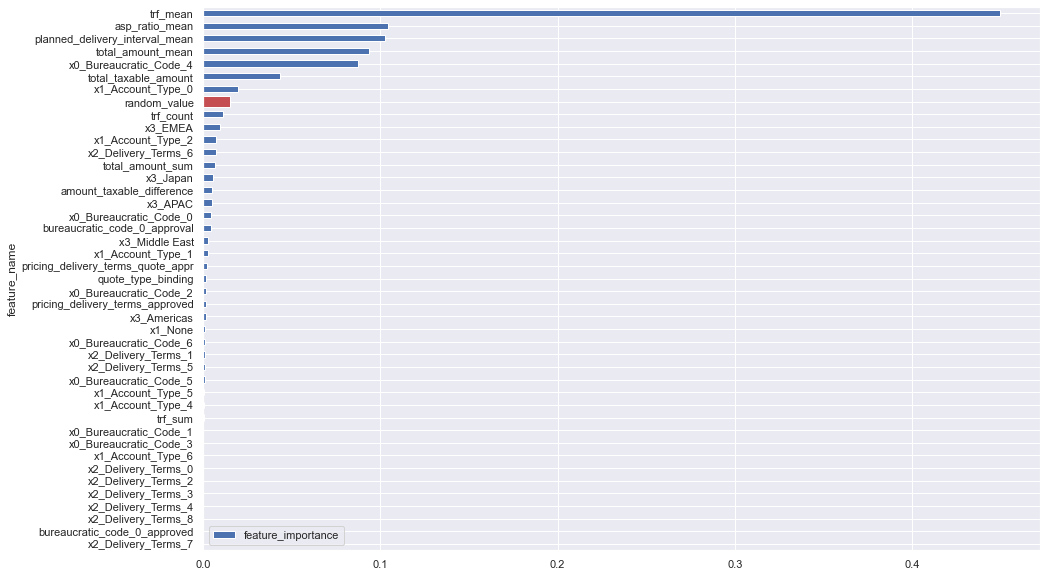

In [124]:
cols_feature_importance = tree.best_estimator_.feature_importances_
total_columns_s = pd.Series(total_columns)

most_important_features = None

if CHECK_FEATURE_IMPORTANCE:
    random_variable_importance = cols_feature_importance[-1]
    print('random variable importance:', random_variable_importance)
    print('columnas más importantes que la variable random:\n', 
          total_columns_s[cols_feature_importance > random_variable_importance])
    
    feature_importance_df  = pd.DataFrame({
        'feature_name': total_columns_s, 
        'feature_importance': cols_feature_importance
    }).sort_values('feature_importance').reset_index(drop=True)

    ax = (feature_importance_df
             .plot.barh(x='feature_name', figsize=(15, 10)))

    random_feature_row = (
        feature_importance_df[feature_importance_df
                                  .feature_name.eq('random_value')]
        .reset_index().iloc[0])
    
    index = random_feature_row[0]
    value = random_feature_row[-1]

    print(index, value)
    most_important_features = feature_importance_df[['feature_name', 'feature_importance']][index + 1:]
    print(most_important_features)
    _  = ax.barh([index], [value], color='r')
most_important_features

In [125]:
most_important_features = list(most_important_features.feature_name)

In [126]:
# def filter_data_most_important_feature(data, most_important_features)

log_loss test: 1.7257171609329618
Train score 0.8367152390031323
Test score 0.7589869281045751


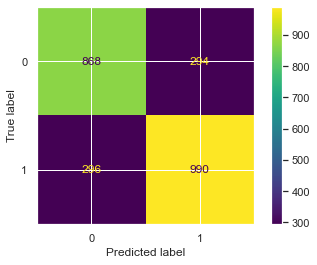

In [127]:
models['basic_des_tree'].fit(X_train[most_important_features], y_train)
show_model_stats(models['basic_des_tree'].best_estimator_, 
                 X_train[most_important_features], 
                 X_test[most_important_features], 
                 y_train, y_test)

### DecisionTree usando ```most_important_features```

---

In [128]:
# transformer_imprtance = BasicTransformer(enc, imp_mean, most_important_features.feature_name, columns_to_use_num)

## Random Forest

In [129]:
from threading import Thread

In [130]:
%%time
from sklearn.ensemble import RandomForestClassifier
best_params = {
    'bootstrap': True,
    'max_features': 'auto',
    'max_depth': 15,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 1200,
}
clf_randforest = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
"""
Best params:
"""

clf = GridSearchCV(clf_randforest, param_grid={
#     'bootstrap': [True, False],
    'max_depth': [7, 15, 20],
#     'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [10, 15, 20],
    'n_estimators': [1100, 1200, 1300],
}, n_jobs=7)

# clf.fit(X_train, y_train)

models['random_forest_gs'] = clf

Wall time: 16 ms


In [131]:
def run_random_forest_gs():
    models['random_forest_gs'].fit(X_train, y_train)
    print(models['random_forest_gs'].best_params_)
    
# Thread(target=run_random_forest_gs).start()


In [132]:
clf_randforest.fit(X_train, y_train)
models['random_forest'] = clf_randforest

log_loss test: 0.42832245833025256
Train score 0.8807027100640066
Test score 0.8080065359477124


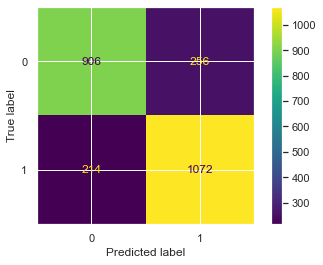

In [133]:
show_model_stats(clf_randforest, X_train, X_test, y_train, y_test)

---

### XGBoost

In [134]:
from xgboost import XGBClassifier
best_params = {
    'min_child_weight': [1, 5, 10],
}
param_grid = {
        'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
}
clf_XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# bestParametersXGB
# clf_XGB_cv = GridSearchCV(clf_XGB, 
#                        param_grid=param_grid, 
#                        n_jobs=4,
#                        cv=3)

# clf_XGB_cv.fit(X_train, y_train)
# clf_XGB = clf_XGB_cv.best_estimator_
# clf_XGB_cv.best_params_
# # models['random_forest_gs'] = clf

log_loss test: 0.44828451070898334
Train score 0.9275500476644424
Test score 0.8022875816993464


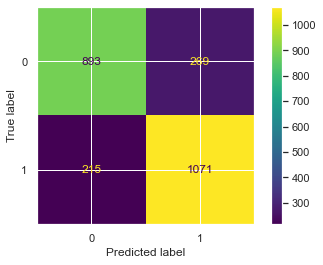

In [135]:
clf_XGB.fit(X_train, y_train)

show_model_stats(clf_XGB, X_train, X_test, y_train, y_test)

In [136]:
models['xgboost'] = clf_XGB

---

### LighGBM

In [137]:
from lightgbm import LGBMClassifier

param_grid = {
    'n_estimators': [400, 700, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15,20,25],
#     'num_leaves': [50, 100, 200],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
#     'min_split_gain': [0.3, 0.4],
#     'subsample': [0.7, 0.8, 0.9],
#     'subsample_freq': [20]
}

clf_LGBM = LGBMClassifier()

# clf_LGBM = GridSearchCV(clf_LGBM, param_grid=param_grid, cv=3)

clf_LGBM.fit(X_train[most_important_features], y_train)

# models['random_forest_gs'] = clf

LGBMClassifier()

log_loss test: 0.45195894845894424
Train score 0.8510145717009396
Test score 0.7900326797385621


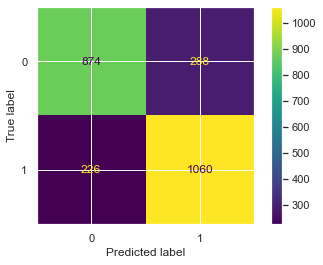

In [139]:
show_model_stats(clf_LGBM, X_train[most_important_features], X_test[most_important_features], y_train, y_test)

In [140]:
models['lightgbm'] = clf_LGBM

### Bag Ensemble

log_loss test: 0.46094333696772316
Train score 0.8356257660356803
Test score 0.7777777777777778


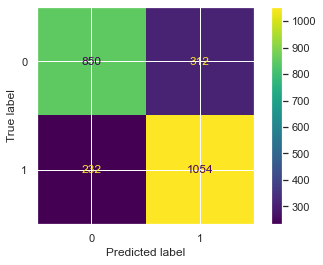

In [141]:
from sklearn.ensemble import BaggingClassifier
# TODO: Aggregate on final model (with VotingClassifier)
bag_clf = (BaggingClassifier(tree.best_estimator_,
                             max_samples=0.5, max_features=0.5)
           .fit(X_train, y_train))
show_model_stats(bag_clf, X_train, X_test, y_train, y_test)

### AdaBoost

log_loss test: 0.6911214726340614
Train score 0.7974942121748604
Test score 0.7712418300653595
Wall time: 7.62 s


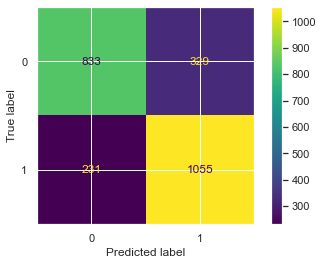

In [142]:
%%time
"""
# first_iteration
 param_grid={
    'n_estimators': [80, 100, 500],
}
best_param = {'n_estimators': 500}
log_loss test: 0.6908309321790898
Train score 0.7919106632166689
Test score 0.7790032679738562
n_jobs=8
Wall time: 54.5 s

# second_iteration
param_grid={
    'n_estimators': [400, 500, 600],
}
best_params {'n_estimators': 600}
log_loss test: 0.6911845348789579
Train score 0.7920468473376004
Test score 0.7785947712418301
Wall time: 37.7 s

# third_iteration (scoring='neg_log_loss')
Almost the same log_loss
"""
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=600, 
                           random_state=RANDOM_STATE)

# model = GridSearchCV(model, param_grid={
#     'n_estimators': [550, 600, 650],
# }, n_jobs=4)

model.fit(X_train, y_train)
# print("best_params", model.best_params_)
# model = model.best_estimator_
show_model_stats(model, X_train, X_test, y_train, y_test)
models['adaboost'] = model

43
random variable importance: 0.135
columnas más importantes que la variable random: 38       asp_ratio_mean
39    total_amount_mean
dtype: object
40 0.135
         feature_name  feature_importance
40       random_value            0.135000
41     asp_ratio_mean            0.150000
42  total_amount_mean            0.161667


array([0.00166667, 0.        , 0.        , 0.00166667, 0.00166667,
       0.        , 0.00166667, 0.00333333, 0.00166667, 0.00166667,
       0.00166667, 0.00166667, 0.00333333, 0.00333333, 0.00166667,
       0.00333333, 0.00333333, 0.00166667, 0.005     , 0.005     ,
       0.00333333, 0.00166667, 0.        , 0.00833333, 0.        ,
       0.        , 0.        , 0.        , 0.00666667, 0.        ,
       0.00166667, 0.00166667, 0.00166667, 0.09166667, 0.06      ,
       0.035     , 0.02      , 0.08166667, 0.15      , 0.16166667,
       0.11833333, 0.07833333, 0.135     ])

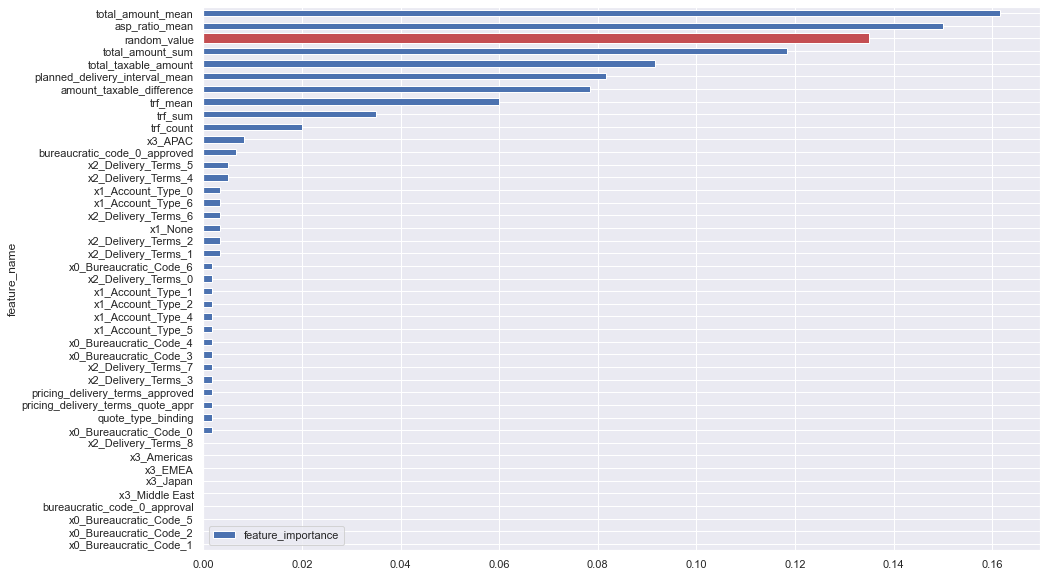

In [143]:
cols_feature_importance = model.feature_importances_
total_columns_s = pd.Series(total_columns)
print(len(cols_feature_importance))

if CHECK_FEATURE_IMPORTANCE:
    random_variable_importance = cols_feature_importance[-1]
    print('random variable importance:', random_variable_importance)
    print('columnas más importantes que la variable random:', 
          total_columns_s[cols_feature_importance > random_variable_importance])
    feature_importance_df  = pd.DataFrame({
        'feature_name': total_columns_s, 
        'feature_importance': cols_feature_importance
    }).sort_values('feature_importance').reset_index(drop=True)

    ax = (feature_importance_df
             .plot.barh(x='feature_name', figsize=(15, 10)))

    random_feature_row = (
        feature_importance_df[feature_importance_df
                                  .feature_name.eq('random_value')]
        .reset_index().iloc[0])
    index = random_feature_row[0]
    value = random_feature_row[-1]

    print(index, value)
    print(feature_importance_df[['feature_name', 'feature_importance']][index:])
    _  = ax.barh([index], [value], color='r')
model.feature_importances_

---

---

### Catboost test

Catboost toma significativamente más tiempo de entrenar que los modelos de sklearn, se requiere la utilización de ```n_jobs```, particularmente cuando se está realizando GridSearch.

In [144]:
%%time

from catboost import CatBoostClassifier
cat_features_cb = columns_to_use_cat
all_features_cb = columns_to_use_cat + columns_to_use_num
labels_cb = opp_df.stage
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(opp_df[all_features_cb], labels_cb)
model_cb = CatBoostClassifier(depth=11, iterations=80)
"""
# first_iteration
param_grid={
    'iterations': [30, 50, 80],
    'depth': [2, 5, 9, 15],
}
best_param = {'depth': 9, 'iterations': 80}
log_loss test: 0.40992019879628866
Train score 0.8314040582868037
Test score 0.8218954248366013

# second_iteration
param_grid={
    'iterations': [80, 90],
    'depth': [7, 9, 11],
}

best_param = {'depth': 11, 'iterations': 80}
n_jobs=None
Wall time: 4min 22s
n_jobs=8

Wall time: 1min 49s
log_loss test: 0.4369047000924161
Train score 0.8514231240637342
Test score 0.7904411764705882
"""
model_cb = GridSearchCV(model_cb, param_grid={
    'iterations': [80, 100, 150],
    'depth': [8, 9, 10],
}, n_jobs=None)

model_cb.fit(X_train_cb, y_train_cb, cat_features=cat_features_cb, 
             verbose=False)
print("best_params", model_cb.best_params_)
model_cb = model_cb.best_estimator_
final_model_cb = model_cb
models['catboost'] = model_cb

best_params {'depth': 10, 'iterations': 100}
Wall time: 4min 34s


In [145]:
sorted(zip(all_features_cb, final_model_cb.get_feature_importance()), key=lambda x: -x[1])

[('planned_delivery_interval_mean', 14.828693374769232),
 ('pricing_delivery_terms_approved', 10.121875541091148),
 ('asp_ratio_mean', 10.000741785811119),
 ('account_type', 8.834760639536524),
 ('total_amount_mean', 8.043207011333127),
 ('bureaucratic_code', 7.4073427409861985),
 ('region', 6.822612042003458),
 ('trf_count', 5.789717083122508),
 ('total_taxable_amount', 4.944103363400615),
 ('total_amount_sum', 4.699526925953478),
 ('delivery_terms', 4.199235535129255),
 ('trf_mean', 4.002109175482769),
 ('bureaucratic_code_0_approval', 3.284044395730916),
 ('pricing_delivery_terms_quote_appr', 2.318116706448314),
 ('trf_sum', 1.8830619236829342),
 ('bureaucratic_code_0_approved', 1.4243331181285466),
 ('amount_taxable_difference', 1.187111280843849),
 ('quote_type_binding', 0.2094073565460108)]

log_loss test: 0.4418582166089827
Train score 0.8484270734032412
Test score 0.795751633986928


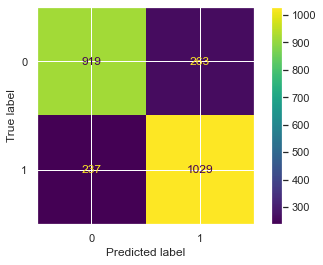

In [146]:
show_model_stats(final_model_cb, X_train_cb, X_test_cb, y_train_cb, y_test_cb)


In [147]:
if 'stage' in common_data_columns:
    common_data_columns.remove('stage')
_, submit_opp_df_cb = tune_dataset(submit_df, common_data_columns)

log_loss test: 0.5534461948575261
Train score 0.49679967315810974
Test score 0.7434588385449904


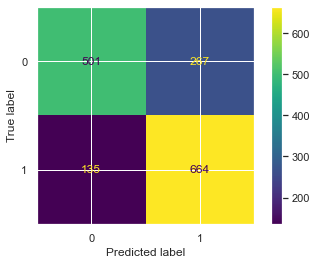

In [148]:
X_submit = submit_opp_df_cb[all_features_cb]
test_over_submit_approximation(final_model_cb, X_submit, X_train_cb)

In [149]:
result = prepare_submit(final_model_cb, X_submit, 'catboost-third-iteration')
result.head()

,opportunity_id,target
0,10689,0.506941
1,10690,0.266734
2,10691,0.844010
3,10692,0.675320
4,10693,0.936750


---

## VotingClassifier Ensemble

In [150]:
models

{'basic_des_tree': GridSearchCV(estimator=DecisionTreeClassifier(random_state=22),
              param_grid={'max_depth': [8, 10, 15],
                          'min_samples_split': [8, 9, 10, 11]}),
 'random_forest_gs': GridSearchCV(estimator=RandomForestClassifier(max_depth=15, min_samples_leaf=2,
                                               min_samples_split=10,
                                               n_estimators=1200,
                                               random_state=22),
              n_jobs=7,
              param_grid={'max_depth': [7, 15, 20],
                          'min_samples_leaf': [2, 3, 4],
                          'min_samples_split': [10, 15, 20],
                          'n_estimators': [1100, 1200, 1300]}),
 'random_forest': RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=10,
                        n_estimators=1200, random_state=22),
 'xgboost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
  

In [151]:
models.pop('catboost', None)
models.pop('random_forest_gs', None)

GridSearchCV(estimator=RandomForestClassifier(max_depth=15, min_samples_leaf=2,
                                              min_samples_split=10,
                                              n_estimators=1200,
                                              random_state=22),
             n_jobs=7,
             param_grid={'max_depth': [7, 15, 20],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [1100, 1200, 1300]})

model: basic_des_tree
log_loss test: 1.7257171609329618
Train score 0.8367152390031323
Test score 0.7589869281045751
model: random_forest
log_loss test: 0.4455330956325093
Train score 0.8738935040174316
Test score 0.7965686274509803
model: xgboost
log_loss test: 0.4763162566049883
Train score 0.89282309682691
Test score 0.7773692810457516
model: lightgbm
log_loss test: 0.45195894845894424
Train score 0.8510145717009396
Test score 0.7900326797385621
model: adaboost
log_loss test: 0.6916884856478752
Train score 0.783467247718916
Test score 0.7577614379084967


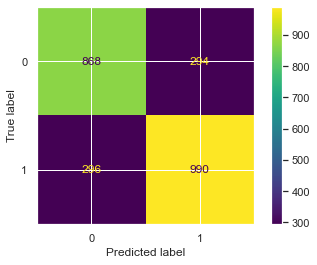

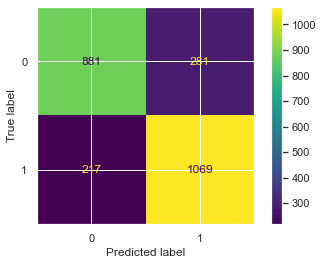

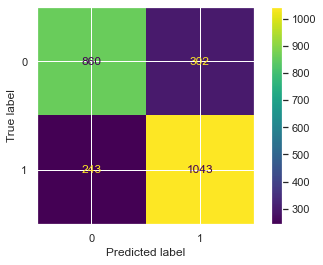

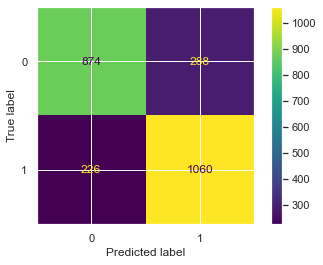

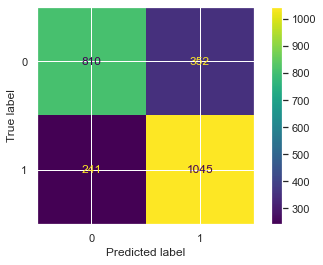

In [152]:
for name, model in models.items():
    print(f'model: {name}')
    model.fit(X_train[most_important_features], y_train)
    show_model_stats(model, 
                     X_train[most_important_features],
                     X_test[most_important_features],
                     y_train, y_test)

In [153]:
from sklearn.ensemble import VotingClassifier

In [154]:
vclf = VotingClassifier(estimators=list(models.items()), voting='soft')

In [155]:
vclf.fit(X_train[most_important_features], y_train)

VotingClassifier(estimators=[('basic_des_tree',
                              GridSearchCV(estimator=DecisionTreeClassifier(random_state=22),
                                           param_grid={'max_depth': [8, 10, 15],
                                                       'min_samples_split': [8,
                                                                             9,
                                                                             10,
                                                                             11]})),
                             ('random_forest',
                              RandomForestClassifier(max_depth=15,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     n_estimators=1200,
                                                     random_state=22)),
                             ('xgboost',
    

log_loss test: 0.46750382445972066
Train score 0.8732125834127741
Test score 0.7867647058823529


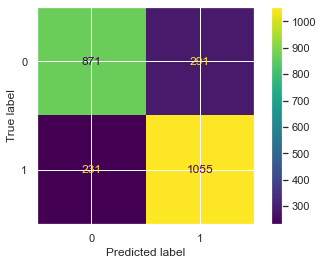

In [156]:
show_model_stats(vclf, X_train[most_important_features], X_test[most_important_features], y_train, y_test)

In [157]:
# """
# Last submit:
# Sales qty: 2551
# Opportunities qty: 1567
# log_loss test: 0.567005550638147
# Train score 0.8512869399428027
# Test score 0.7345245692405871
# """

# X_submit = create_submit_X_data(submit_df, common_data_columns, transformer)
# test_over_submit_approximation(vclf, X_submit, X_train)
# result = prepare_submit(vclf, X_submit, 'voting-ens_ada-rand-dec')

# result.head()

In [167]:
submit_df.T

,0,1,2,3,4,5,6,7,8,9,...,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550
id,6140,6146,6151,6118,6124,6129,6135,6218,11530,20314,...,14091,5817,11318,27867,16339,16345,15218,15224,7286,11263
region,EMEA,EMEA,EMEA,EMEA,EMEA,EMEA,EMEA,EMEA,Americas,Americas,...,EMEA,Japan,Japan,EMEA,EMEA,EMEA,Americas,Americas,Americas,EMEA
territory,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,NE America,NW America,...,Norway,Japan,None,Belgium,KSA,KSA,SE America,SE America,NE America,Belgium
pricing_delivery_terms_quote_appr,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
pricing_delivery_terms_approved,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
bureaucratic_code_0_approval,1,1,1,1,1,1,1,1,0,1,...,1,0,0,1,0,0,0,1,0,0
bureaucratic_code_0_approved,1,1,1,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0
submitted_for_approval,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
bureaucratic_code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_2,...,Bureaucratic_Code_2,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5
account_created_date,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00,2019-02-16 00:00:00,2013-07-27 00:00:00,...,2018-04-19 00:00:00,2017-06-30 00:00:00,2019-02-12 00:00:00,2015-06-17 00:00:00,2017-06-12 00:00:00,2017-06-12 00:00:00,2018-06-08 00:00:00,2018-06-08 00:00:00,2018-08-29 00:00:00,2016-03-03 00:00:00


In [168]:
"""
Last submit:
Sales qty: 2551
Opportunities qty: 1567
log_loss test: 0.567005550638147
Train score 0.8512869399428027
Test score 0.7345245692405871
"""
X_submit = create_submit_X_data(submit_df, common_data_columns, transformer)
X_submit

# test_over_submit_approximation(vclf, X_submit, X_train[most_important_features])
# result = prepare_submit(vclf, X_submit)
# # , 'voting-ens_ada-rand-dec-xboost-ligh-most-important_features')

# result.head()

Sales qty: 2551
Opportunities qty: 1567


ValueError: Shape of passed values is (1567, 42), indices imply (1567, 25)

log_loss test: 0.47251969948025624
Train score 0.8431158926869127
Test score 0.795751633986928


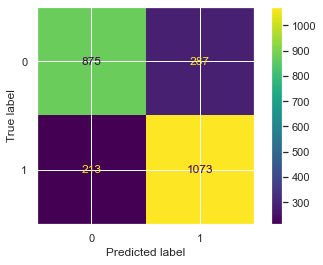

In [159]:
from sklearn.ensemble import BaggingClassifier
bag_clf = (BaggingClassifier(vclf,
                             max_samples=0.5, max_features=0.5)
           .fit(X_train, y_train))
show_model_stats(bag_clf, X_train, X_test, y_train, y_test)

In [160]:
X_submit = create_submit_X_data(submit_df, common_data_columns, transformer)
test_over_submit_approximation(bag_clf, X_submit, X_train)

Sales qty: 2551
Opportunities qty: 1567


ValueError: Number of features of the model must match the input. Model n_features is 43 and input n_features is 42.

### Estimación de target en test
Como `sales_contract_no` revela en gran parte el target, se lo calculara en el set de test para poder hacer pruebas locales.

In [ ]:
X_submit = create_submit_X_data(submit_df, common_data_columns, transformer)
test_over_submit_approximation(tree, X_submit, X_train)

In [ ]:
%%time
X_submit = create_submit_X_data(submit_df, common_data_columns, transformer)

result = prepare_submit(tree, X_submit)

result.head()

In [ ]:
%%time
model = models['random_forest']
X_submit = create_submit_X_data(submit_df, common_data_columns, transformer)
test_over_submit_approximation(model, X_submit, X_train)
result = prepare_submit(model, X_submit, 'random-forest')

result.head()
